In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, OPTICS
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import davies_bouldin_score, silhouette_score

In [202]:
#pip install threadpoolctl -U

<h1 style="color:blue">About Data</h1>
<p>
    The data collected from a direct marketing campaign by a Portuguese bank. The goal of the campaign was to persuade clients to subscribe to a term deposit. The dataset includes various attributes related to the clients, such as demographic information, job status, and previous interactions with the bank, along with details about the marketing campaign itself, including call duration, contact method, and campaign outcomes. The target variable is whether the client subscribed to the term deposit, making this dataset suitable for classification tasks, particularly in predicting customer behavior.
</p>

<h1 style="color:red">Baseline Pipiline</h1>

In [18]:
# Load Data
def Load_data():
    data = pd.read_csv('./Bank-Data.csv')
    return data

In [33]:
# Data Cleaning
def CleanFunc(data):
    # Impute missing values (mean/mode imputation)
    for column in data.columns:
        if data[column].dtype == 'object':
            # Use mode for categorical columns
            data[column].fillna(data[column].mode()[0], inplace=True)
        else:
            #  mean for numerical columns
            data[column].fillna(data[column].mean(), inplace=True)
    print(f"Data after imputing missing values: {data.shape}")
    
    # One-hot encoding for categorical variables
    categorical_cols = data.select_dtypes(include=['object']).columns
    data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)
    
    return data

## Preprocessing steps all in one fucnions

In [54]:
def preprocessing(data,columns,dropna=False,replace_outliers=False,scale=False,target=None,):

#Drop columns with missing values greater than 40% of total values
    cols = data.columns[data.isna().sum() * 100 / len(data) > 40]
    data.drop(columns=cols, axis=1, inplace=True)
    print(f"Dropped columns with more than 40% missing values: {list(cols)}")

    if target:
        # Drop any row in target with missing values
        initial_rows = data.shape[0]
        data.drop(data[data[target].isna()].index, inplace=True)
        dropped_rows = initial_rows - data.shape[0]
        print(f"Dropped {dropped_rows} rows with missing target values.")

    if dropna:
        # Drop any row with missing values
        initial_rows = data.shape[0]
        data.dropna(inplace=True)
        dropped_rows = initial_rows - data.shape[0]
        print(f"Dropped {dropped_rows} rows with missing values.")

    if replace_outliers:
        outliers_replaced = 0
        for col in columns:
            # Skip categorical columns (if any)
            if data[col].dtype == object:
                continue
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            # Replace outliers with Minimum and Maximum values
            before_outliers = data[col].isna().sum()
            data[col] = np.where(
                data[col] < (Q1 - (1.5 * IQR)),
                Q1 - 1.5 * IQR,
                np.where(data[col] > (Q3 + (1.5 * IQR)), Q3 + (1.5 * IQR), data[col]),
            )
            after_outliers = data[col].isna().sum()
            outliers_replaced += before_outliers - after_outliers
        data.fillna(0, inplace=True)
        print(f"Replaced {outliers_replaced} outliers.")

    if scale:
        numerical_columns = split_categorical_and_numeric(data)[1]
        # Scale the data such that all columns are in the range 0 to 1
        scaler = StandardScaler()
        data[numerical_columns] = scaler.fit_transform(
            data[numerical_columns]
        )  # Scaling and normalizing numerical data
        print(f"Scaled columns: {columns}")

    return data


# Feature Engineering

In [39]:
def feature_engineering(df):
    # List All Unique Values in 'Income_Category'
    unique_income_categories = df['Income_Category'].unique()
    print(unique_income_categories)

    unique_education_level_categories = df['Education_Level'].unique()
    print(unique_education_level_categories)

    # Drop rows where 'Income_Category' is 'Unknown'
    df = df[df['Income_Category'] != 'Unknown']

    # Drop rows where 'Education_Level' is 'Unknown'
    df = df[df['Income_Category'] != 'Unknown']

    income_mapping = {
        'Less than $40K': 0,
        '$40K - $60K': 1,
        '$60K - $80K': 2,
        '$80K - $120K': 3,
        '$120K +': 4
    }

    education_mapping = {
        'Uneducated': 0,
        'High School': 1,
        'College': 2,
        'Graduate': 3,
        'Post-Graduate': 4,
        'Doctorate': 5
    }

    # Apply the mapping to the 'Income_Category' column
    df['Income_Category_Label'] = df['Income_Category'].map(income_mapping)

    # Apply the mapping to the 'Education_Level' column
    df['Education_Level_Label'] = df['Education_Level'].map(education_mapping)

    # drop the original 'Income_Category' column
    df.drop(columns=['Income_Category'], inplace=True)

    # drop the original 'Education_Level' column
    df.drop(columns=['Education_Level'], inplace=True)

    return df  

In [65]:
def split_categorical_and_numeric(data):
    cat_columns = []
    num_columns = []
    col = data.columns
    for i in col:
        if data[i].dtypes == object:
            cat_columns.append(i)
        elif data[i].dtypes == float:
            num_columns.append(i)
        elif data[i].dtypes == int:
            num_columns.append(i)
    return cat_columns, num_columns

# One-Hot Encoding

In [66]:
def encode_categorical(df: pd.DataFrame, cat_cols, encoding_type) -> pd.DataFrame:
    if not cat_cols:
        cat_cols, _ = split_categorical_and_numeric(df)
    if encoding_type == "onehot":
        df = pd.get_dummies(df, columns=cat_cols)
    elif encoding_type == "label":
        LE = LabelEncoder()
        for col in cat_cols:
            df[col] = df[[col]].apply(LE.fit_transform)
    return df

# Dendrogram

In [71]:
def plot_dendogram(df):
    linkage_matrix = linkage(df, method="ward")

    plt.figure(figsize=(50, 30))
    dendrogram(linkage_matrix)
    plt.title("Agg. Hierarchical Clustering Dendogram (Single Linkage)")
    plt.xlabel("Data Points")
    plt.ylabel("Distance")

# Correlation Heatmap

In [70]:
def plot_correlation_matrix(df, figsize=(12, 12)):
    plt.figure(figsize=figsize)
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
    plt.title("Correlation Matrix")
    plt.show()

    print("Descriptive Statistics:")
    print(df.describe())

# TSNE & PCA Analysis

In [72]:
def plot_PCA_TSNE(df: pd.DataFrame):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df)
    _df = df.copy()
    _df["PCA1"] = pca_result[:, 0]
    _df["PCA2"] = pca_result[:, 1]

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="PCA1", y="PCA2", data=_df)

    plt.title("PCA")
    plt.show()

    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(df)
    _df["TSNE1"] = tsne_result[:, 0]
    _df["TSNE2"] = tsne_result[:, 1]

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="TSNE1", y="TSNE2", data=_df)
    
    plt.title("t-SNE")
    plt.show()

    return pca_result, tsne_result, _df

# Reachability Plot

In [28]:
def plot_reachability(optics):
    space = np.arange(len(optics.ordering_))
    reachability = optics.reachability_[optics.ordering_]
    labels = optics.labels_[optics.ordering_]

    plt.figure(figsize=(10, 6))
    colors = sns.color_palette("viridis", np.unique(labels).max() + 1)
    for klass, color in zip(range(0, np.unique(labels).max() + 1), colors):
        Xk = space[labels == klass]
        Rk = reachability[labels == klass]
        plt.plot(
            Xk,
            Rk,
            "o",
            markerfacecolor=color,
            markeredgecolor="k",
            markersize=5,
            alpha=0.5,
        )
    plt.plot(
        space[labels == -1],
        reachability[labels == -1],
        "o",
        markerfacecolor="k",
        markeredgecolor="k",
        markersize=5,
        alpha=0.5,
    )
    plt.ylabel("Reachability (epsilon distance)")
    plt.title("Reachability Plot")
    plt.show()

# DBSCAN Function

In [73]:
def run_dbscan(df_pca, eps_values, min_samples_values):
    num_eps = len(eps_values)
    num_min_samples = len(min_samples_values)

    fig, axes = plt.subplots(num_eps, num_min_samples, figsize=(15, 10))

    for i, eps in enumerate(eps_values):
        for j, min_samples in enumerate(min_samples_values):
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            clusters = dbscan.fit_predict(df_pca)

            sns.scatterplot(
                x=df_pca.iloc[:, 0],
                y=df_pca.iloc[:, 1],
                hue=clusters,
                palette="viridis",
                ax=axes[i, j],
            )
            axes[i, j].set_title(f"eps={eps}, min_samples={min_samples}")
            axes[i, j].legend([], frameon=False)  # Optional: Hide legend in subplots

    plt.tight_layout()
    plt.show()

# OPTICS Fucntion

In [74]:
def run_optics(df_pca, min_samples, max_eps):
    optics = OPTICS(min_samples=min_samples, max_eps=max_eps)
    clusters = optics.fit_predict(df_pca)
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=df_pca.iloc[:, 0], y=df_pca.iloc[:, 1], hue=clusters, palette="viridis"
    )
    plt.title(f"OPTICS Clustering (min_samples={min_samples}, max_eps={max_eps})")
    plt.show()


def run_optics(df_pca, min_samples_values, max_eps_values):
    num_min_samples = len(min_samples_values)
    num_max_eps = len(max_eps_values)

    fig, axes = plt.subplots(num_min_samples, num_max_eps, figsize=(15, 10))

    for i, min_samples in enumerate(min_samples_values):
        for j, max_eps in enumerate(max_eps_values):
            optics = OPTICS(min_samples=min_samples, max_eps=max_eps)
            clusters = optics.fit_predict(df_pca)

            sns.scatterplot(
                x=df_pca.iloc[:, 0],
                y=df_pca.iloc[:, 1],
                hue=clusters,
                palette="viridis",
                ax=axes[i, j],
            )
            axes[i, j].set_title(f"min_samples={min_samples}, max_eps={max_eps}")
            axes[i, j].legend([], frameon=False)  # Optional: Hide legend in subplots

    plt.tight_layout()
    plt.show()

<h1 style="color:green">Calling all Function Sequentially </h1>

In [32]:
data = Load_data()
data

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.999910
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.999940
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.999980
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.999870
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.999980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,...,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462,0.000191,0.999810
10123,710638233,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,...,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511,0.995270,0.004729
10124,716506083,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,...,5409.0,0,5409.0,0.819,10291,60,0.818,0.000,0.997880,0.002118
10125,717406983,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,...,5281.0,0,5281.0,0.535,8395,62,0.722,0.000,0.996710,0.003294


# Data Cleaning fucntion calling

In [35]:
clean_data = CleanFunc(data)
clean_data

Data after imputing missing values: (10127, 23)


,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,...,Marital_Status_Single,Marital_Status_Unknown,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,768805383,45,3,39,5,1,3,12691.0,777,11914.0,...,0,0,0,1,0,0,0,0,0,0
1,818770008,49,5,44,6,1,2,8256.0,864,7392.0,...,1,0,0,0,0,1,0,0,0,0
2,713982108,51,3,36,4,1,0,3418.0,0,3418.0,...,0,0,0,0,1,0,0,0,0,0
3,769911858,40,4,34,3,4,1,3313.0,2517,796.0,...,0,1,0,0,0,1,0,0,0,0
4,709106358,40,3,21,5,1,0,4716.0,0,4716.0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,50,2,40,3,2,3,4003.0,1851,2152.0,...,1,0,1,0,0,0,0,0,0,0
10123,710638233,41,2,25,4,2,3,4277.0,2186,2091.0,...,0,0,1,0,0,0,0,0,0,0
10124,716506083,44,1,36,5,3,4,5409.0,0,5409.0,...,0,0,0,0,0,1,0,0,0,0
10125,717406983,30,2,36,4,3,3,5281.0,0,5281.0,...,0,1,1,0,0,0,0,0,0,0


# Preprocessing steps exectution

In [57]:
data = preprocessing(data, data.columns, dropna=True, replace_outliers=True, scale=True)
data.head()

Dropped columns with more than 40% missing values: []
Dropped 0 rows with missing values.
Replaced 0 outliers.
Scaled columns: Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
      dtype='object')


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,0.802878,Existing Customer,-0.165368,M,0.503368,High School,Married,$60K - $80K,Blue,0.392971,...,0.666325,-0.473422,0.718980,2.436489,-1.297191,-0.973954,2.375918,-0.775882,-0.771590,0.784537
1,2.156861,Existing Customer,0.333718,F,2.043199,Graduate,Single,Less than $40K,Blue,1.036214,...,0.051781,-0.366667,0.092940,2.436489,-1.229194,-1.357433,2.375918,-0.616276,-0.934914,0.917413
2,-0.682769,Existing Customer,0.583262,M,0.503368,Graduate,Married,$80K - $120K,Blue,0.007025,...,-0.618605,-1.426858,-0.457233,2.436489,-0.953506,-1.911349,2.375918,-0.997155,-1.094636,1.094580
3,0.832862,Existing Customer,-0.789227,F,1.273283,High School,Unknown,Less than $40K,Blue,-0.250272,...,-0.633155,1.661686,-0.820230,2.436489,-1.284702,-1.911349,2.375918,1.759686,-0.592085,0.607370
4,-0.814896,Existing Customer,-0.789227,M,0.503368,Uneducated,Married,$60K - $80K,Blue,-1.922704,...,-0.438745,-1.426858,-0.277534,2.436489,-1.448912,-1.570478,2.375918,-0.997155,-1.091980,1.094580


# Feature Engineering calling

In [58]:
data = feature_engineering(data)
data.head()

['$60K - $80K' 'Less than $40K' '$80K - $120K' '$40K - $60K' '$120K +'
 'Unknown']
['High School' 'Graduate' 'Uneducated' 'Unknown' 'College' 'Post-Graduate'
 'Doctorate']


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Marital_Status,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,...,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2,Income_Category_Label,Education_Level_Label
0,0.802878,Existing Customer,-0.165368,M,0.503368,Married,Blue,0.392971,0.763943,-1.414034,...,0.718980,2.436489,-1.297191,-0.973954,2.375918,-0.775882,-0.771590,0.784537,2,1.0
1,2.156861,Existing Customer,0.333718,F,2.043199,Single,Blue,1.036214,1.407306,-1.414034,...,0.092940,2.436489,-1.229194,-1.357433,2.375918,-0.616276,-0.934914,0.917413,0,3.0
2,-0.682769,Existing Customer,0.583262,M,0.503368,Married,Blue,0.007025,0.120579,-1.414034,...,-0.457233,2.436489,-0.953506,-1.911349,2.375918,-0.997155,-1.094636,1.094580,3,3.0
3,0.832862,Existing Customer,-0.789227,F,1.273283,Unknown,Blue,-0.250272,-0.522785,1.810811,...,-0.820230,2.436489,-1.284702,-1.911349,2.375918,1.759686,-0.592085,0.607370,0,1.0
4,-0.814896,Existing Customer,-0.789227,M,0.503368,Married,Blue,-1.922704,0.763943,-1.414034,...,-0.277534,2.436489,-1.448912,-1.570478,2.375918,-0.997155,-1.091980,1.094580,2,0.0


In [68]:
data = encode_categorical(data, None, encoding_type='label')
data.dropna(inplace=True)
data.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Marital_Status,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,...,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2,Income_Category_Label,Education_Level_Label
0,0.802878,1,-0.165368,1,0.503368,1,0,0.392971,0.763943,-1.414034,...,0.718980,2.436489,-1.297191,-0.973954,2.375918,-0.775882,-0.771590,0.784537,2,1.0
1,2.156861,1,0.333718,0,2.043199,2,0,1.036214,1.407306,-1.414034,...,0.092940,2.436489,-1.229194,-1.357433,2.375918,-0.616276,-0.934914,0.917413,0,3.0
2,-0.682769,1,0.583262,1,0.503368,1,0,0.007025,0.120579,-1.414034,...,-0.457233,2.436489,-0.953506,-1.911349,2.375918,-0.997155,-1.094636,1.094580,3,3.0
3,0.832862,1,-0.789227,0,1.273283,3,0,-0.250272,-0.522785,1.810811,...,-0.820230,2.436489,-1.284702,-1.911349,2.375918,1.759686,-0.592085,0.607370,0,1.0
4,-0.814896,1,-0.789227,1,0.503368,1,0,-1.922704,0.763943,-1.414034,...,-0.277534,2.436489,-1.448912,-1.570478,2.375918,-0.997155,-1.091980,1.094580,2,0.0


# Correlation analysis

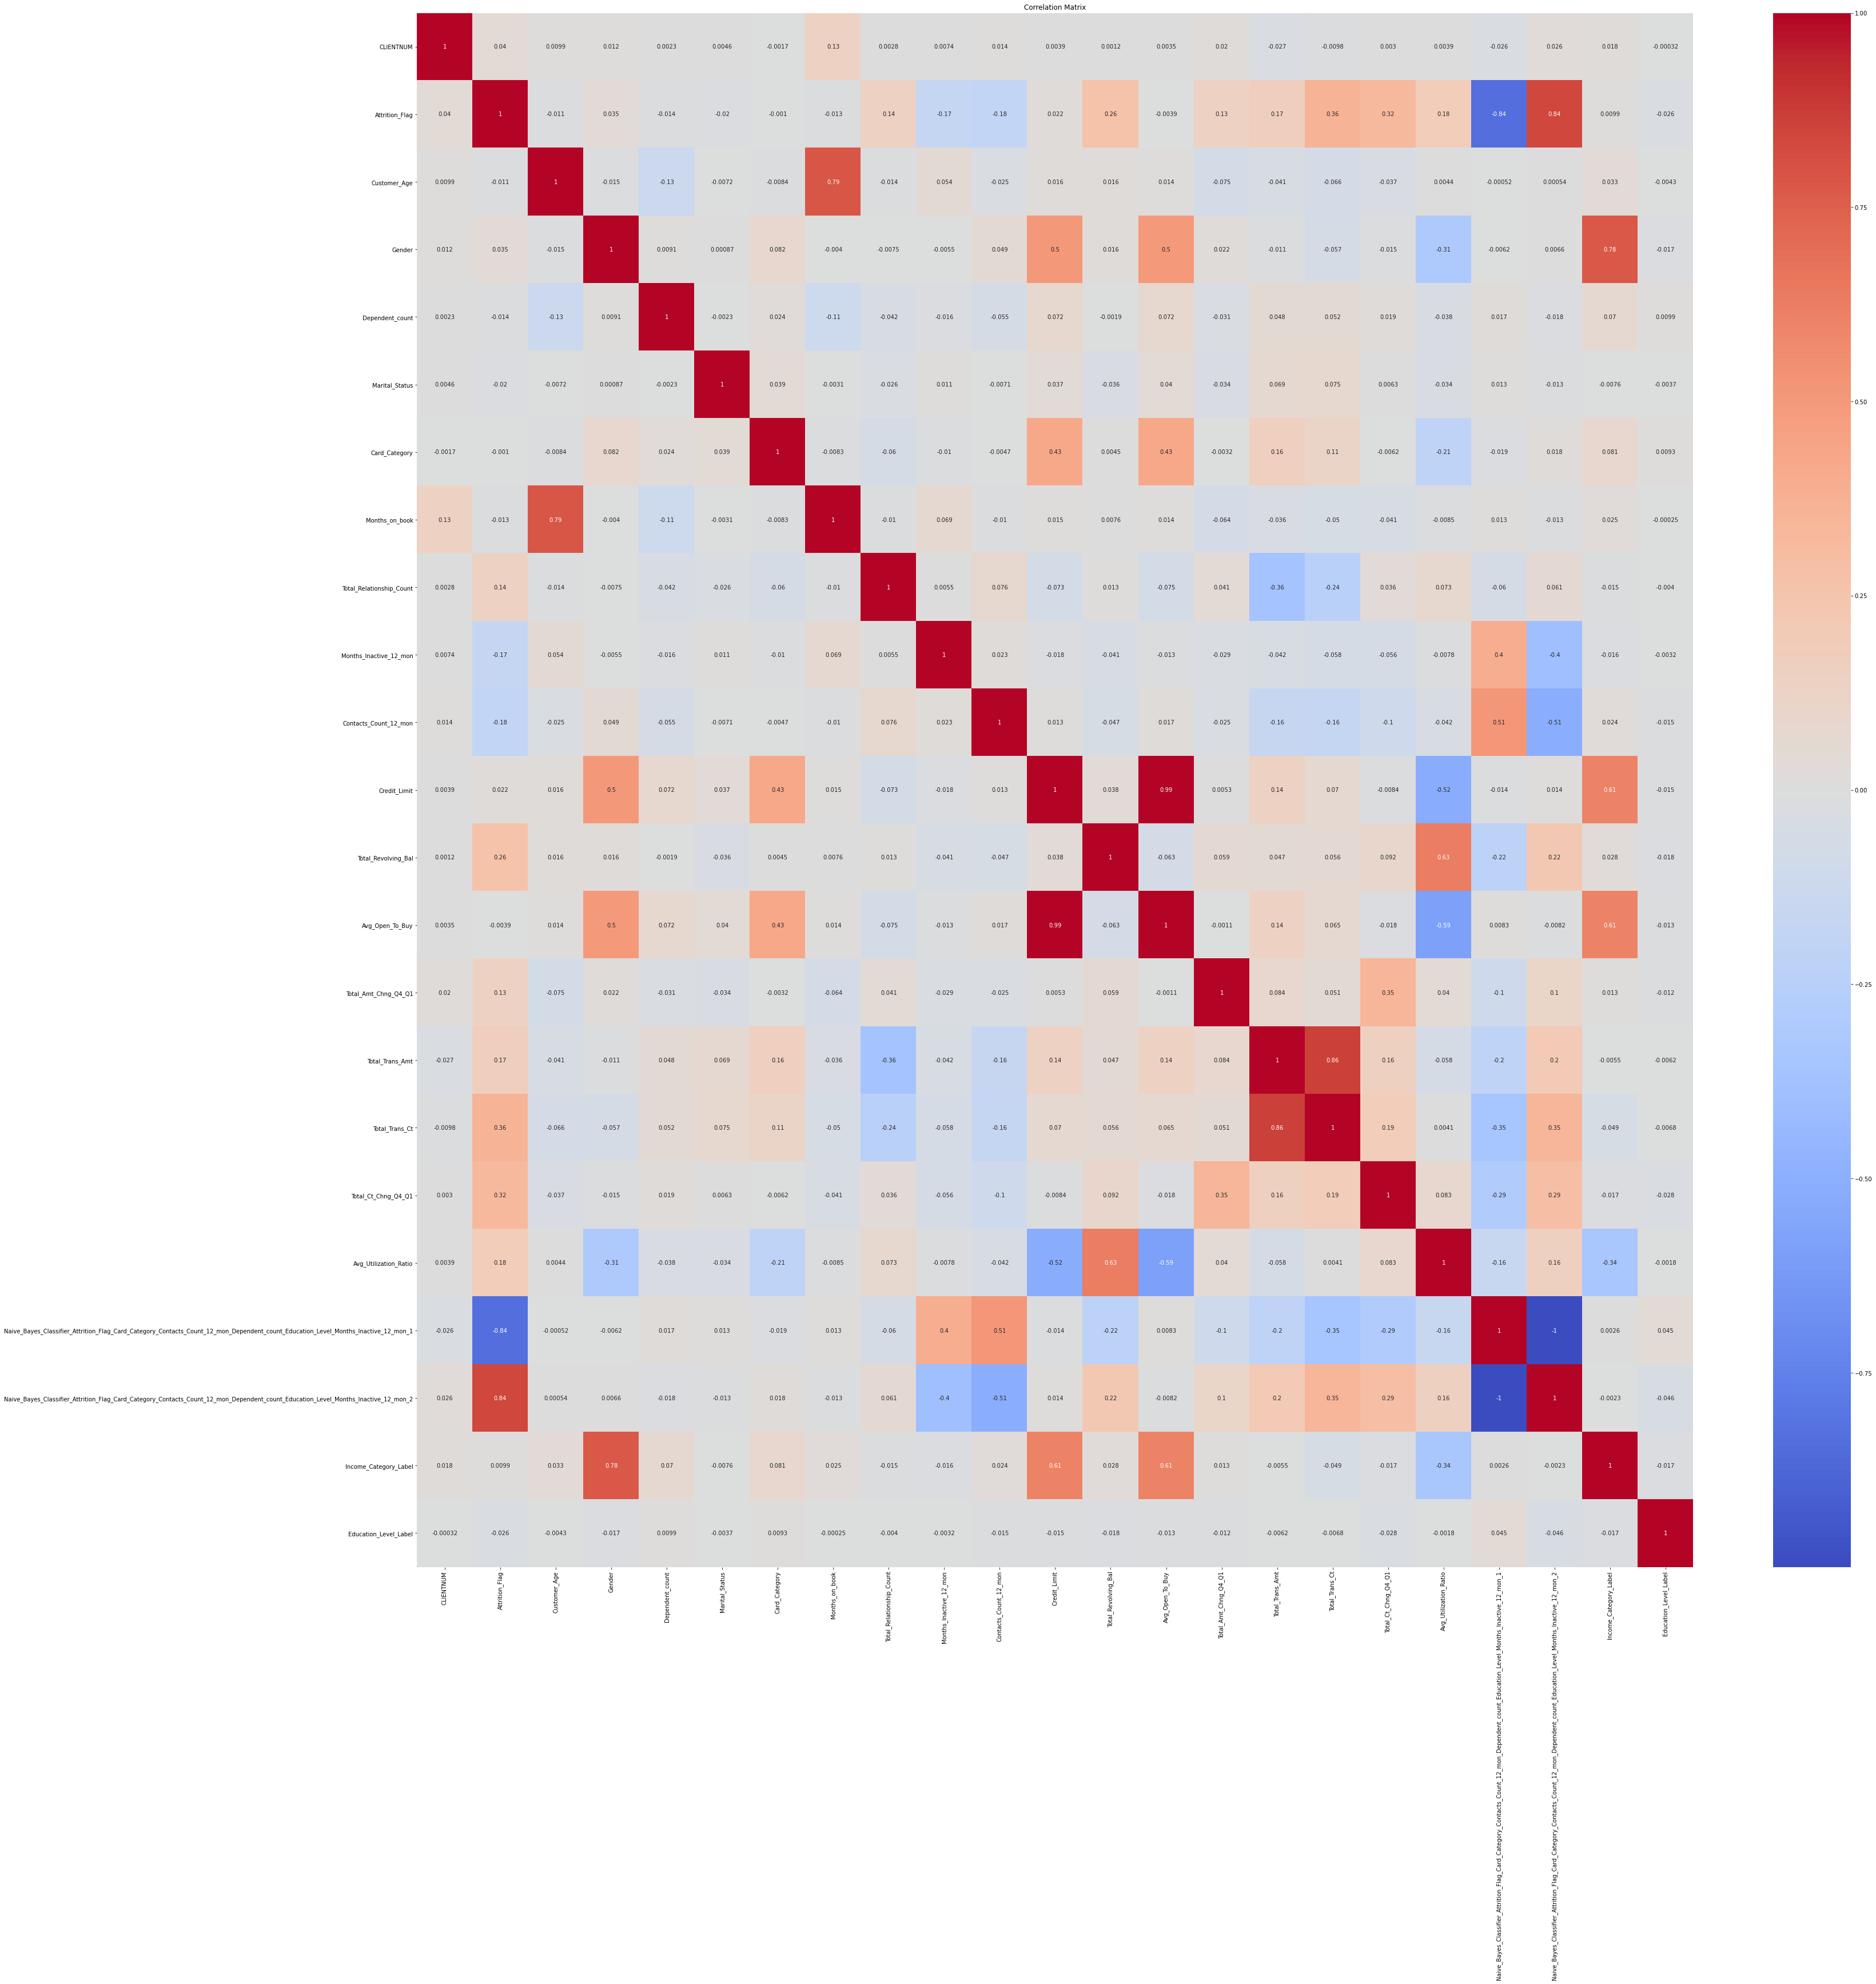

Descriptive Statistics:
         CLIENTNUM  Attrition_Flag  Customer_Age       Gender  \
count  7641.000000     7641.000000   7641.000000  7641.000000   
mean      0.000850        0.841513     -0.002795     0.525455   
std       1.000948        0.365221      0.992740     0.499384   
min      -0.842652        0.000000     -2.536030     0.000000   
25%      -0.708846        1.000000     -0.664455     0.000000   
50%      -0.576711        1.000000     -0.040597     1.000000   
75%       0.924378        1.000000      0.708033     1.000000   
max       2.416280        1.000000      2.766766     1.000000   

       Dependent_count  Marital_Status  Card_Category  Months_on_book  \
count      7641.000000     7641.000000    7641.000000     7641.000000   
mean          0.004097        1.457924       0.184923        0.002050   
std           0.993506        0.737436       0.702809        0.997287   
min          -1.806378        0.000000       0.000000       -2.372974   
25%          -1.036462   

In [77]:
plot_correlation_matrix(data, figsize=(50,50))

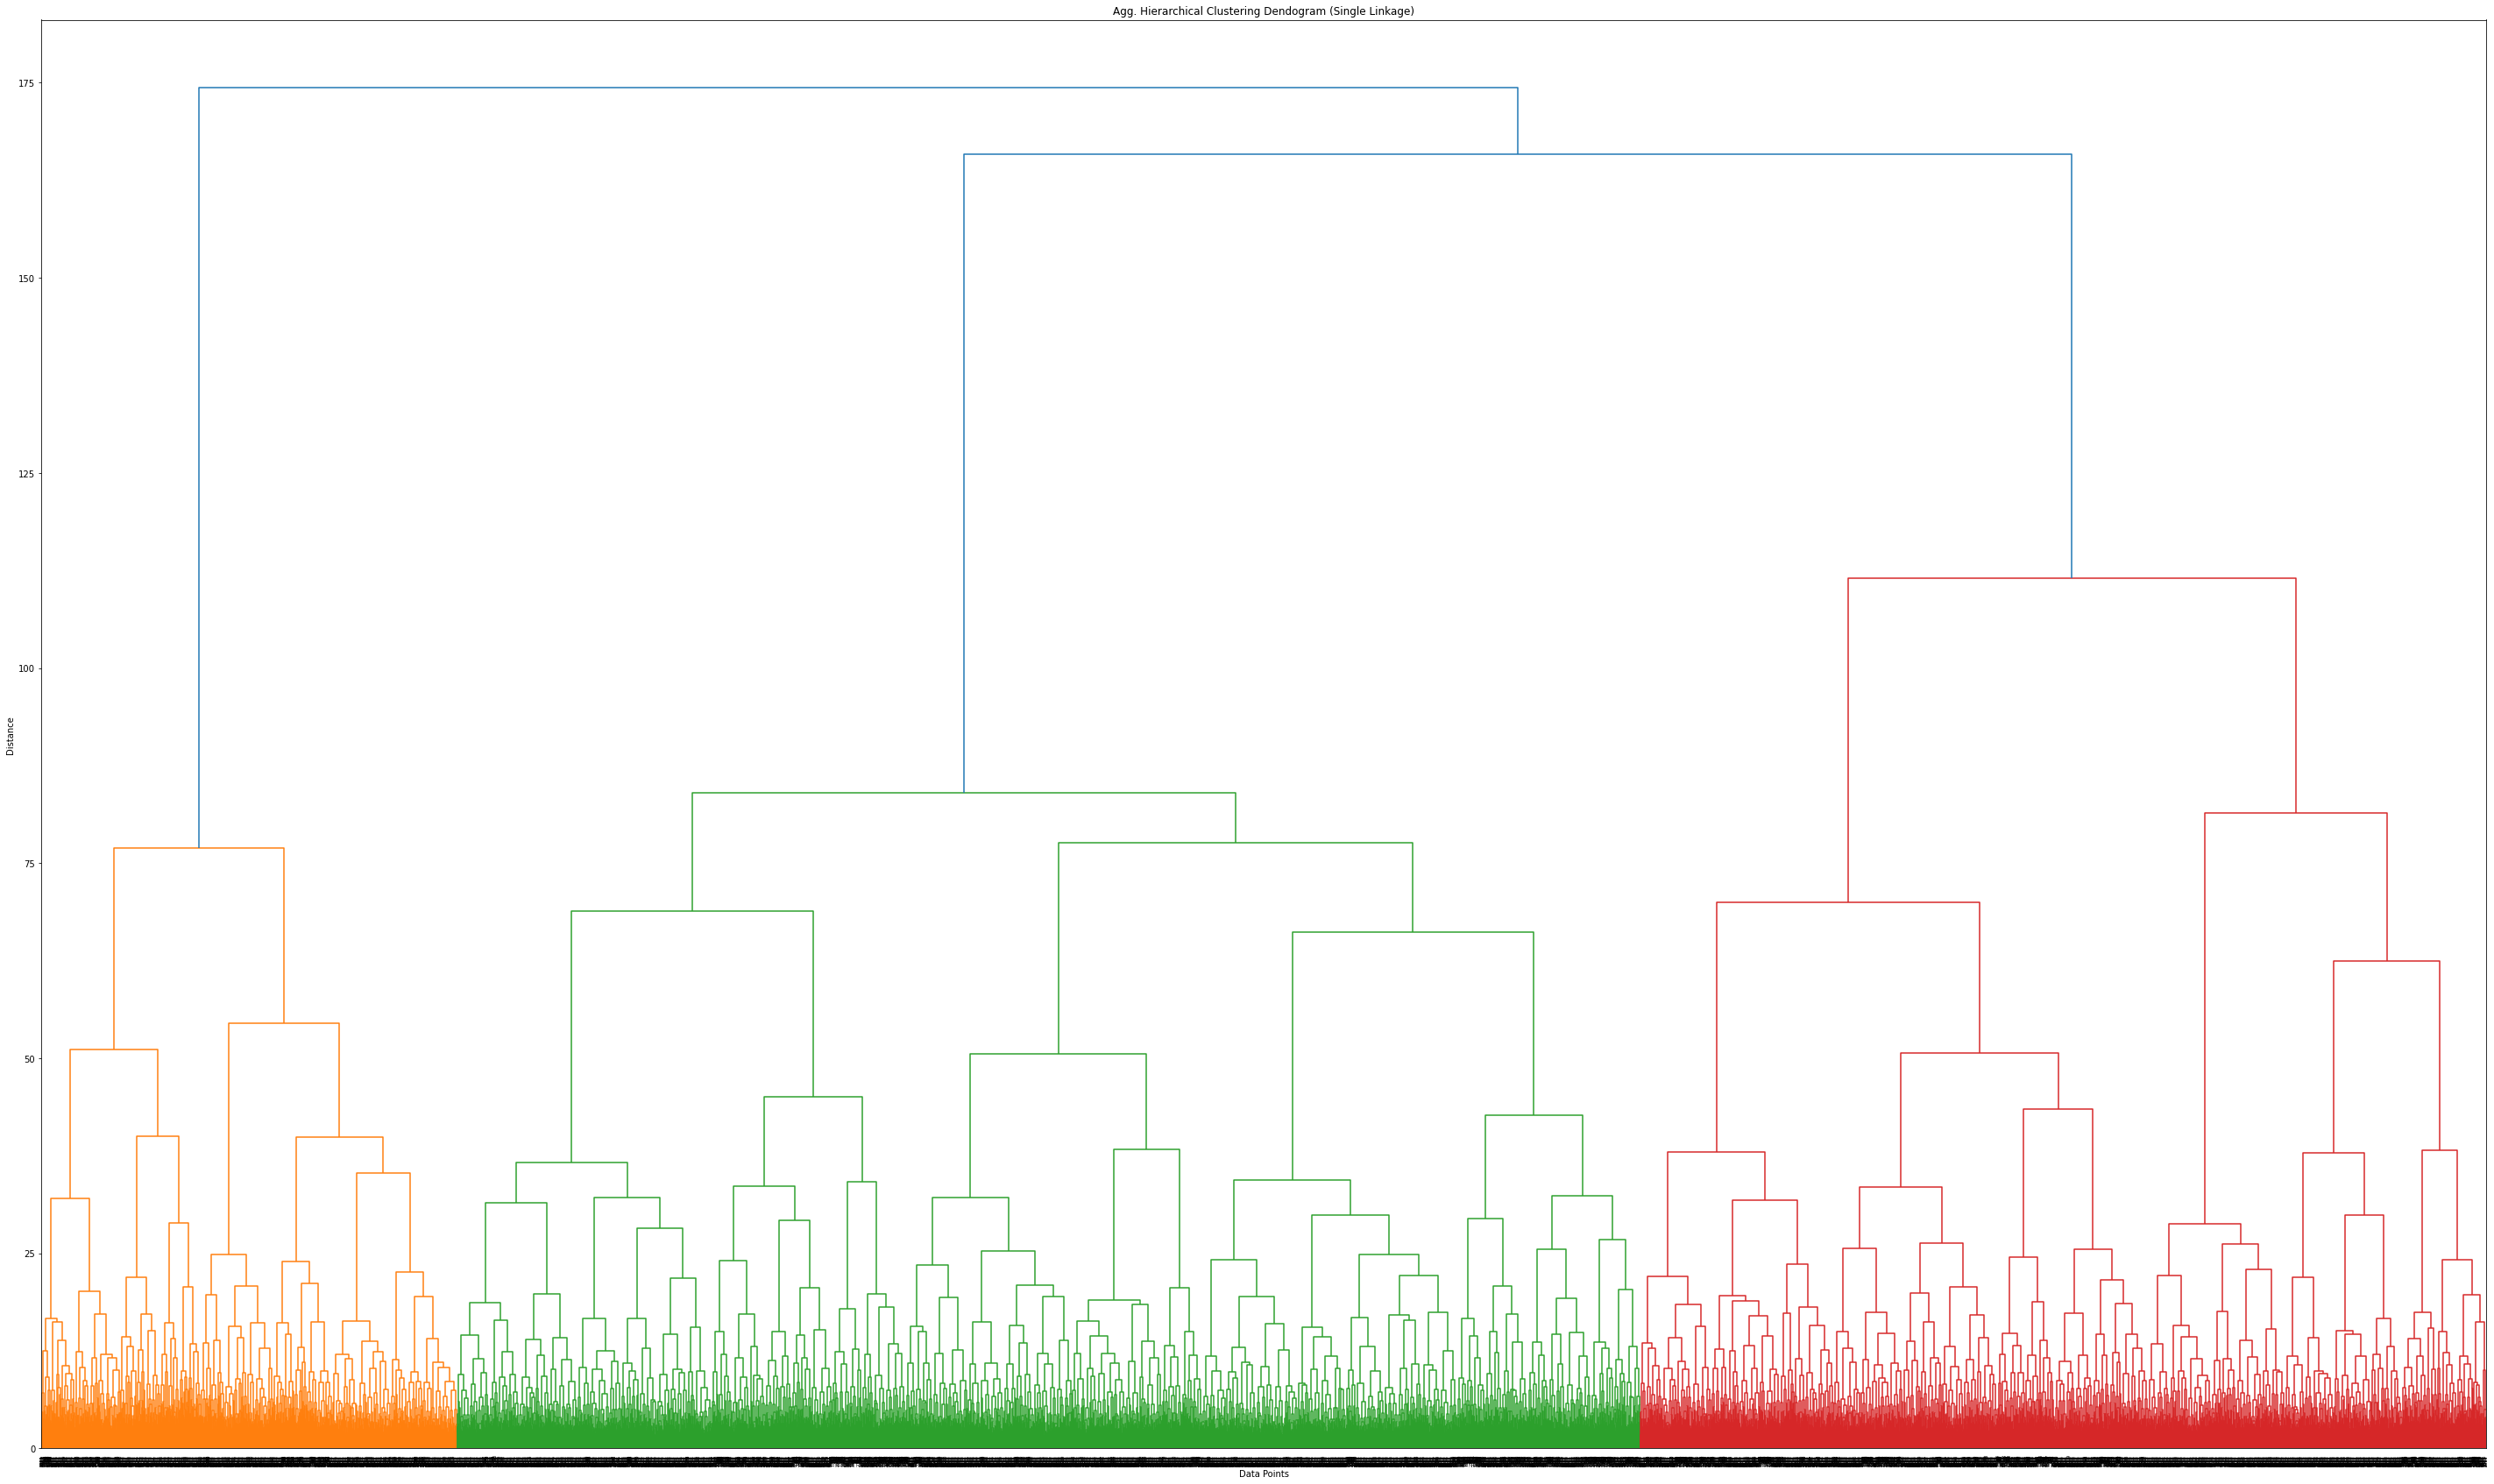

In [78]:
plot_dendogram(data)

In [79]:
pca = PCA(n_components=2)
pca.fit(data)
data_pca = pd.DataFrame(pca.transform(data), columns=(["col1","col2"]))

tsne = TSNE(n_components=2, random_state=42)
data_tsne = pd.DataFrame(tsne.fit_transform(data), columns=["col1", "col2"])

data_pca.head()

C:\Users\mkami\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\mkami\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


,col1,col2
0,1.140810,-1.006472
1,-0.863630,-0.983683
2,0.592762,-1.396075
3,-2.574348,-0.821794
4,0.112615,-1.634217


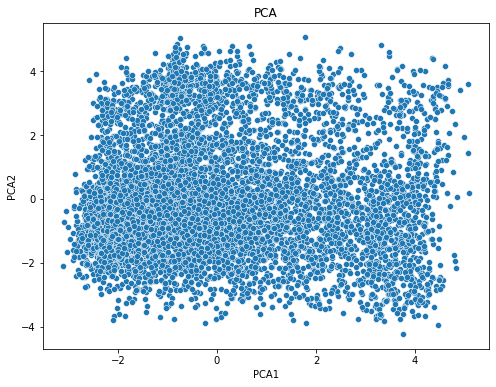

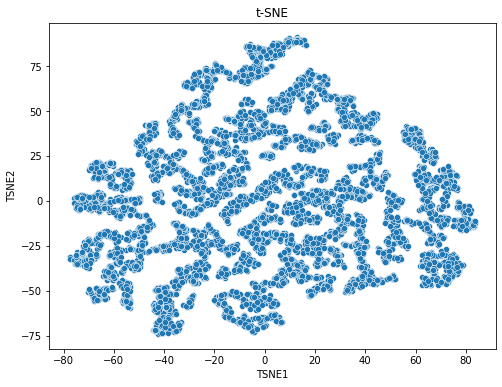

(array([[ 1.14080976, -1.00647159],
        [-0.86362979, -0.98368272],
        [ 0.59276189, -1.3960753 ],
        ...,
        [-0.30798115,  2.24250988],
        [ 0.47713909,  2.17254452],
        [ 0.10530795,  1.69669627]]),
 array([[ 28.316645 , -18.628664 ],
        [-17.581186 , -24.613447 ],
        [ 20.742453 , -29.93431  ],
        ...,
        [  2.5024214,  50.535633 ],
        [ 18.239649 ,  41.049377 ],
        [  5.57787  ,  38.021675 ]], dtype=float32),
           col1      col2      PCA1      PCA2      TSNE1      TSNE2
 0     1.140810 -1.006472  1.140810 -1.006472  28.316645 -18.628664
 1    -0.863630 -0.983683 -0.863630 -0.983683 -17.581186 -24.613447
 2     0.592762 -1.396075  0.592762 -1.396075  20.742453 -29.934311
 3    -2.574348 -0.821794 -2.574348 -0.821794 -74.563812 -29.755878
 4     0.112615 -1.634217  0.112615 -1.634217  12.224894 -39.974861
 ...        ...       ...       ...       ...        ...        ...
 7636 -1.086149 -1.382910 -1.086149 -1.382910 -

In [80]:
plot_PCA_TSNE(data_pca)

<h1 style="color:red">DBSCAN Fucntion calling</h1>

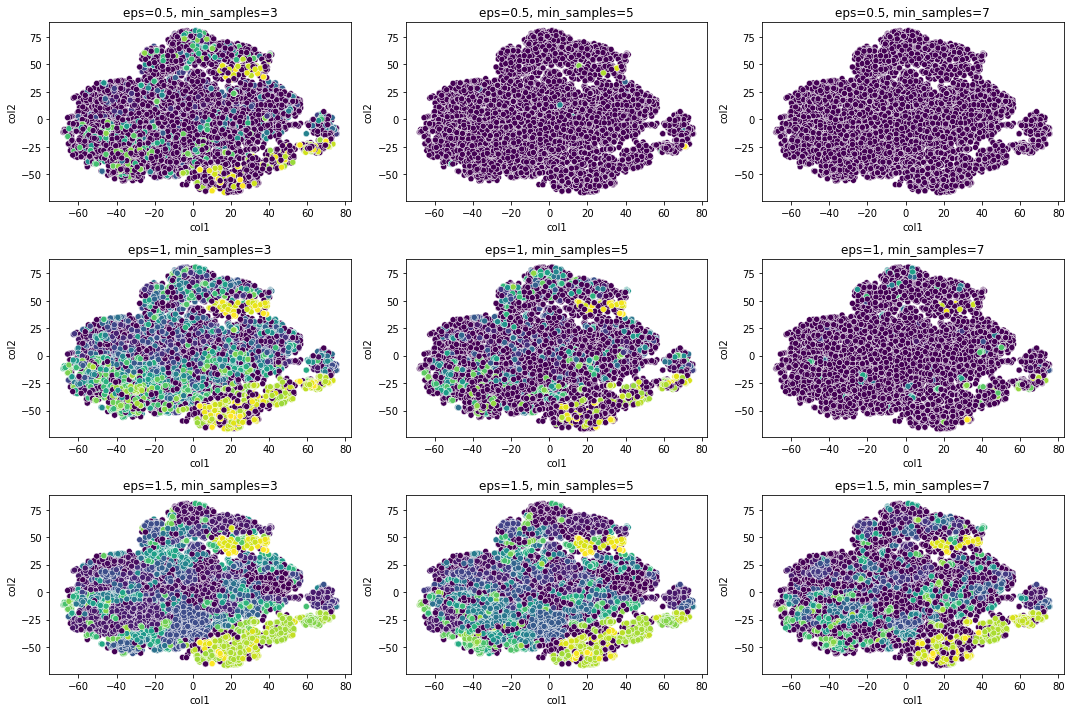

In [82]:
eps_values = [0.5, 1, 1.5]
min_samples_values = [3, 5, 7]
run_dbscan(data_tsne, eps_values, min_samples_values)

<h1 style="color:red">OPTICS Fucntion calling</h1>

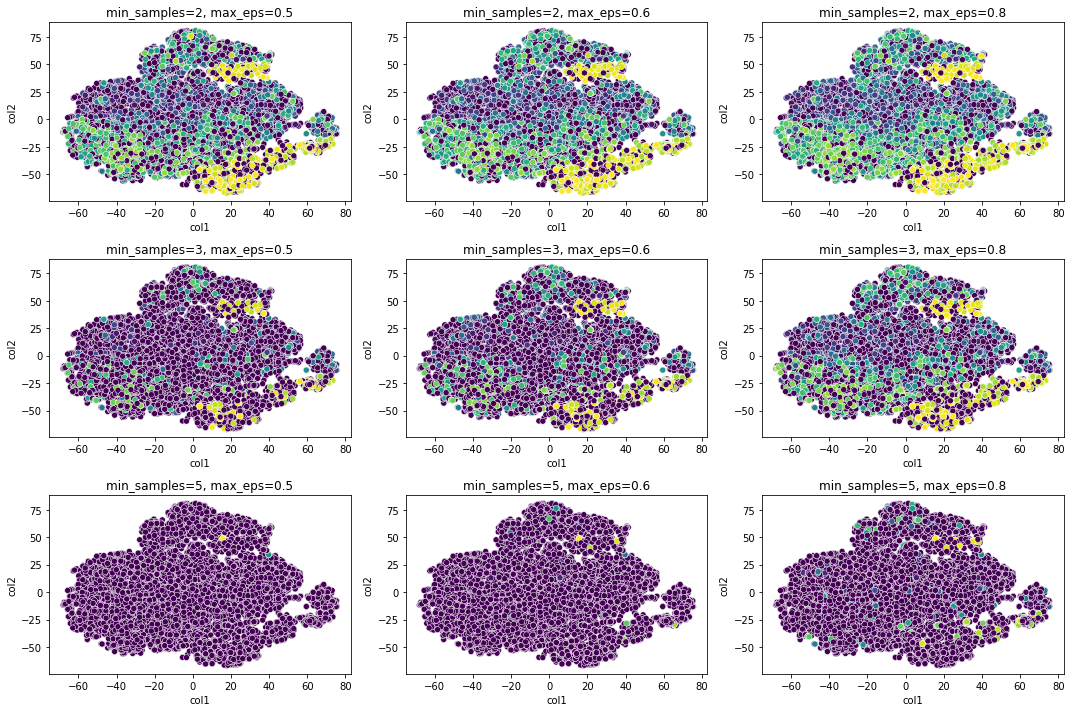

In [84]:
max_eps_values = [0.5, 0.6, 0.8]
min_samples_values = [2, 3, 5]
run_optics(data_tsne, min_samples_values, max_eps_values)

<h1 style="color:blue">Reachability Plot</h1>

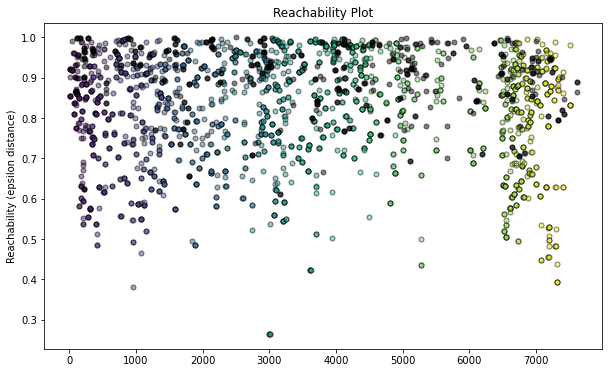

In [85]:
optics = OPTICS(min_samples=5, max_eps=1).fit(data_tsne)
plot_reachability(optics)

# Interpretation on Word File